# Part 1 Pandas Dataset

In [1]:
from bikesharing import prepare_bike_sharing

In [2]:
df_train, df_test = prepare_bike_sharing()

In [3]:
from torch.utils.data import Dataset

/home/paul/workspaces/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
df_train

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
74,75,1,0,3,0,3,1,2,0.365217,0.776522,0.203117,2192
19,20,1,0,1,0,4,1,2,0.261667,0.538333,0.195904,1927
190,191,3,0,7,0,0,0,1,0.747500,0.578333,0.183471,4881
191,192,3,0,7,0,1,1,1,0.762500,0.635833,0.282337,4086
517,153,2,1,6,0,5,1,2,0.654167,0.755417,0.237563,4127
...,...,...,...,...,...,...,...,...,...,...,...,...
84,85,2,0,3,0,6,0,1,0.265833,0.394167,0.209571,2496
96,97,2,0,4,0,4,1,1,0.437500,0.602917,0.162312,3141
571,207,3,1,7,0,3,1,1,0.724167,0.450000,0.164800,8173
173,174,3,0,6,0,4,1,2,0.728333,0.703333,0.238804,4790


In [5]:
from dataclasses import dataclass, field
from typing import Any, List, Tuple
import numpy as np
import pandas as pd
import torch


@dataclass(eq=False)
class PandasDataset(torch.utils.data.Dataset):
    '''df: pandas dataframe
    target_col: name of the target column for prediction
    cat_cols: list of column names with categorical variables
    '''
    df: pd.DataFrame
    target_col: str
    cat_cols: List[str] = field(default_factory=list)

    def __new__(cls, *args, **kwargs):
        obj = object.__new__(cls)
        Dataset.__init__(obj)
        return obj

    def __post_init__(self):
        # transform into internal numpy representation
        df_c = self.df.copy()
        self._target = df_c[self.target_col].to_numpy(dtype=np.float32)

        # shift the following columns one to the right because embedding layer wants emb that start from 0
        df_c[["season", "mnth", "weathersit"]] = df_c[["season", "mnth", "weathersit"]] - 1
        self._categorical_values = df_c[self.cat_cols].to_numpy()
        # ugly cast to list, because append modifies the list which we do not want
        cont_cols = [col for col in df_c.columns if col not in self.cat_cols + [self.target_col]]
        self._continuos_values = df_c[cont_cols].to_numpy(dtype=np.float32)
            
        
    def __len__(self) -> int:
        return len(self.df)
    
    def __getitem__(self, idx: int):
        #should return np.array for continuous variables, np.array of categorical variables, target_value (for given idx)
        # dataloader does the casting to tensor
        return self._continuos_values[idx], self._categorical_values[idx], self._target[idx]

In [31]:
ds_train = PandasDataset(df_train, "cnt", ["season","yr","mnth","holiday","weekday","workingday","weathersit"])
ds_test  = PandasDataset(df_test, "cnt", ["season","yr","mnth","holiday","weekday","workingday","weathersit"])

In [41]:
from torch.utils.data import DataLoader

BATCH_SIZE: int = 256

dl_train = DataLoader(ds_train, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
dl_test = DataLoader(ds_test, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)
print(next(iter(dl_train))[0].shape)

torch.Size([256, 4])


# Part 2 Model training

In [33]:
# Model class

class CatMlp(torch.nn.Module):

    def __init__(self) -> None:
        super().__init__()

        self.season = torch.nn.Embedding(4, 4)
        self.year = torch.nn.Embedding(2, 2)
        self.month = torch.nn.Embedding(12, 12)
        self.holiday = torch.nn.Embedding(2, 2)
        self.weekday = torch.nn.Embedding(7, 7)
        self.workingday = torch.nn.Embedding(2, 2)
        self.weathersit = torch.nn.Embedding(3, 3)
        self.cat_layers = [self.season, self.year, self.month, self.holiday, self.weekday, self.workingday, self.weathersit]
        
        self.cont_mlp = torch.nn.Sequential(
            torch.nn.Linear(4, 68),
            torch.nn.ReLU(),
        )
        
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(100, 300),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(300, 100),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(100, 1),
        )

    def forward(self, cont_in: torch.Tensor, cat_in: torch.Tensor):
        emb_out = []
        for i, emb_layer in enumerate(self.cat_layers):
            eo = emb_layer(cat_in[::, i])
            emb_out.append(eo)
        emb_out_tensor = torch.cat(emb_out, dim=1)
        x_cont = self.cont_mlp(cont_in)
        x = torch.cat((emb_out_tensor, x_cont), dim=1)
        x = self.mlp(x).flatten()
        return x, emb_out_tensor

In [34]:
torch.set_printoptions(sci_mode=False)

def eval_model(model):
    model.eval() 

    preds=[]
    targs=[]
    for x_cont, x_cat, y_batch in dl_test:
        pred, _ = model(x_cont, x_cat)
        preds.append(pred)
        targs.append(y_batch)

    preds = torch.cat(preds,axis=0)
    targs = torch.cat(targs,axis=0)

    mse = torch.nn.functional.mse_loss(preds, targs)
    return mse
 

# Training 
I did the training with kaggle, so there is no output for the following cells.
I am loading the best model later.

In [ ]:
EPOCHS: int = 60000
print_loss_every_n_iterations = 400
total_iterations = EPOCHS * len(dl_train)

In [12]:
model = CatMlp()
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.MSELoss()

print_loss_every_n_iterations = 100
total_iterations = EPOCHS * len(dl_train)

In [14]:
from tqdm.notebook import tqdm
import copy


def train(model, optimizer, criterion):
    iteration_number = 0 
    best_loss = None
    best_model_state_dict = None
    best_val_loss = None
    val_loss = None

    for epoch in tqdm(range(EPOCHS)):
        model.train()
        for x_cont, x_cat, y_batch in dl_train:
            # zero the parameter gradients
            x_cont = x_cont.cuda()
            x_cat = x_cat.cuda()
            y_batch = y_batch.cuda()
            optimizer.zero_grad()
            # forward + backward + optimize
            y_pred = model(x_cont, x_cat)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            iteration_number += 1
            
            if best_loss is None or loss.item() < best_loss[0]:
                best_loss = (loss.item(), iteration_number)
                best_model = copy.deepcopy(model)
            if iteration_number % print_loss_every_n_iterations == 0:
                print(f'Iteration {iteration_number} of {total_iterations} with best loss of: {best_loss} and best_val_loss: {best_val_loss}')
        
        # So this is cheating, but it is not forbidden ;)
        model.eval() 
        preds=[]
        targs=[]
        for x_cont, x_cat, y_batch in dl_test:
            x_cont = x_cont.cuda()
            x_cat = x_cat.cuda()
            y_batch = y_batch.cuda()
            #collect targets and predictions by iterating through the test loader
            preds.append(model(x_cont, x_cat).detach())
            targs.append(y_batch)

        preds = torch.cat(preds,axis=0).cuda()
        targs = torch.cat(targs,axis=0).cuda()
        
        val_loss = criterion(preds, targs)
        if best_val_loss is None or val_loss.item() < best_val_loss[0]:
            best_val_loss = (val_loss.item(), iteration_number)
            best_model_val = copy.deepcopy(model)
        
    return best_model, best_model_val

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
best_models = []
for i in tqdm(range(10)):
    model = CatMlp()
    model = model.cuda()
    optimizer = torch.optim.Adam(model.parameters())
    criterion = torch.nn.MSELoss()
    #br_m2, sd_m2 = train(model2, optimizer2, criterion)
    bm, bm_val = train(model, optimizer, criterion)
    best_models.append(bm_val)

In [ ]:
# Save the best model
from pathlib import Path

best_mse = None
best_val_model = None
for i, m in enumerate(best_models):
    mse = eval_model(m.cpu())
    if best_mse is None or mse < best_mse:
        best_mse = mse
        best_val_model = i
        
        
p = Path("./saves/")
p.mkdir(parents=True, exist_ok=True)
torch.save(best_models[best_val_model].state_dict(), p / "model1")

# Local again

In [35]:
# load best model
from pathlib import Path
model_path = Path("./saved_models/bike_sharing/model1")
model = CatMlp()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


<All keys matched successfully>

In [36]:
#obtain test predictions
model.eval() #put model into eval mode (for dropout, batchnorm etc)
# mse = eval_model(model)
# print(f"Results on the test set: \nMSE: {mse} RMSE: {torch.sqrt(mse)}")

CatMlp(
  (season): Embedding(4, 4)
  (year): Embedding(2, 2)
  (month): Embedding(12, 12)
  (holiday): Embedding(2, 2)
  (weekday): Embedding(7, 7)
  (workingday): Embedding(2, 2)
  (weathersit): Embedding(3, 3)
  (cont_mlp): Sequential(
    (0): Linear(in_features=4, out_features=68, bias=True)
    (1): ReLU()
  )
  (mlp): Sequential(
    (0): Linear(in_features=100, out_features=300, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=300, out_features=100, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=100, out_features=1, bias=True)
  )
)

# Part c 
Visualization with pca

In [44]:
from sklearn.decomposition import PCA
decompositions = []
x, x_, _ = next(iter(dl_train), 2)
_, pred_cat = model(x, x_)
pred_cat = pred_cat.detach().numpy()[::, 20:27]
print(pred_cat.shape)
pca = PCA(2)
decompositions.append(("hallo", pca.fit_transform(pred_cat)))


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

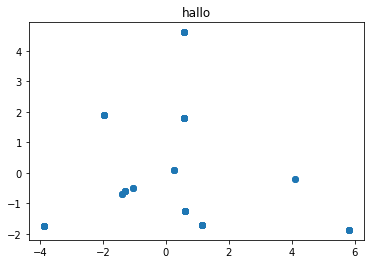

In [30]:
import matplotlib.pyplot as plt

for decomposition in decompositions:
    name, deco = decomposition
    d0 = deco[::, 0]
    d1 = deco[::, -1]
    plt.title(name)
    plt.scatter(d0, d1)
    plt.show()

# Use XGBoost RandomForrestRegressor as a comparison 

In [31]:
# modify data

def split_x_y(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    x = df[filter(lambda col: col != "cnt", df.columns)]
    y = df["cnt"]
    return x, y

x_train, y_train = split_x_y(df_train)
x_test, y_test = split_x_y(df_test)

In [33]:
import xgboost as xgb
rfg = xgb.XGBRFRegressor()

rfg.fit(x_train, y_train)

XGBRFRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
               grow_policy='depthwise', importance_type=None,
               interaction_constraints='', max_bin=256, max_cat_threshold=64,
               max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=0, num_parallel_tree=100,
               objective='reg:squarederror', predictor='auto', random_state=0,
               reg_alpha=0, ...)

In [40]:
y_pred = rfg.predict(x_test)
mse = sum((y_pred - y_test) ** 2)
rmse = np.sqrt(mse)
print(f"MSE: {mse}, RMSE: {rmse}")

MSE: 29847985.824216217, RMSE: 5463.331019095971
